# Develop approximate negative log-likelihood for preliminary optimization

In [1]:
from __future__ import annotations

import numdifftools as nd
import numpy as np

from numpy.typing import ArrayLike
from scipy.fft import rfft, irfft, rfftfreq
from scipy.optimize import minimize
from matplotlib import pyplot as plt
from matplotlib.figure import figaspect
from scipy.optimize import approx_fprime
from numpy.random import default_rng

import thztools as thz

## Define function

In [2]:
def tdnll_appx(
    x: ArrayLike,
    delta: ArrayLike,
    logv: ArrayLike,
    a: ArrayLike,
    eta: ArrayLike,
    ts: float,
    *,
    fix_logv: bool,
    fix_delta: bool,
    fix_a: bool,
    fix_eta: bool,
) -> tuple[float, np.ndarray]:
    r"""
    Compute approximate negative log-likelihood for the time-domain noise model.

    Computes the negative log-likelihood function for obtaining the
    data matrix `x` given `delta`, `logv`, `a`, and `eta`.

    Parameters
    ----------
    x : array_like
        Data matrix.
    delta : array_like
        Deviation vector with shape (n,).
    logv : array_like
        Array of three noise parameters.
    a: array_like
        Amplitude vector with shape (m,).
    eta : array_like
        Delay vector with shape (m,).
    ts : float
        Sampling time.
    fix_logv : bool
        Exclude noise parameters from gradiate calculation when ``True``.
    fix_delta : bool
        Exclude signal vector from gradiate calculation when ``True``.
    fix_a : bool
        Exclude amplitude vector from gradiate calculation when ``True``.
    fix_eta : bool
        Exclude delay vector from gradiate calculation when ``True``.

    Returns
    -------
    nll : float
        Negative log-likelihood.
    gradnll : array_like
        Gradient of the negative log-likelihood function with respect to free
        parameters.
    """
    x = np.asarray(x)
    logv = np.asarray(logv)
    delta = np.asarray(delta)
    a = np.asarray(a)
    eta = np.asarray(eta)

    m, n = x.shape

    # Compute variance
    v = np.exp(logv)

    # Compute mu
    scale = thz.noiseamp(np.sqrt(v), x[0, :], ts)
    mu = x[0, :] - delta * scale

    # Compute frequency vector and Fourier coefficients of mu
    f = rfftfreq(n, ts)
    w = 2 * np.pi * f
    mu_f = rfft(mu)
    x_f = rfft(x)

    exp_iweta = np.exp(1j * np.outer(eta, w))
    zeta_f = ((np.conj(exp_iweta) * mu_f).T * a).T
    zeta = irfft(zeta_f, n=n)

    # Compute negative - log likelihood and gradient

    # Compute residuals and their squares for subsequent computations
    res = x - zeta
    ressq = res**2

    # Alternative case: A, eta, or both are not set to defaults
    dzeta = irfft(1j * w * zeta_f, n=n)
    dx = irfft(1j * w * x_f, n=n)

    valpha = v[0]
    vbeta = v[1] * x**2
    vtau = v[2] * dx**2
    vtot = valpha + vbeta + vtau

    resnormsq = ressq / vtot
    nll = (
        m * n * np.log(2 * np.pi) / 2
        + np.sum(np.log(vtot)) / 2
        + np.sum(resnormsq) / 2
    )

    # Compute gradient
    gradnll = np.array([])
    if not (fix_logv & fix_delta & fix_a & fix_eta):
        reswt = res / vtot
        dvar = (vtot - ressq) / vtot**2
        if not fix_logv:
            # Gradient wrt logv
            gradnll = np.append(gradnll, 0.5 * np.sum(dvar) * v[0])
            gradnll = np.append(gradnll, 0.5 * np.sum(x**2 * dvar) * v[1])
            gradnll = np.append(gradnll, 0.5 * np.sum(dx**2 * dvar) * v[2])
        if not fix_delta:
            # Gradient wrt mu
            gradnll = np.append(
                gradnll,
                np.sum((irfft(exp_iweta * rfft(reswt), n=n).T * a).T, axis=0)
                * scale,
            )
        if not fix_a:
            # Gradient wrt A
            dnllda = -np.sum(reswt * zeta, axis=1).T / a
            # Exclude first term for consistency with MATLAB version
            gradnll = np.append(gradnll, dnllda[1:])
        if not fix_eta:
            # Gradient wrt eta
            dnlldeta = np.sum(reswt * dzeta, axis=1)
            # Exclude first term for consistency with MATLAB version
            gradnll = np.append(gradnll, dnlldeta[1:])

    return nll, gradnll

## Simulate measurements

In [3]:
rng = np.random.default_rng(0)
n = 256
m = 64
ts = 0.05
t = np.arange(n) * ts
mu, _ = thz.thzgen(n, ts=ts, t0=n * ts / 3)
sigma = np.array([1e-5, 1e-2, 1e-3])
noise = thz.noiseamp(sigma, mu, ts) * rng.standard_normal((m, n))
x = np.array(mu + noise)
delta = np.zeros(n)
a = np.ones(m)
eta = np.zeros(m)

## Check gradient

In [5]:
logv = np.log(sigma**2)
_, grad_delta_tdnll = tdnll_appx(
    x,
    delta,
    logv,
    a,
    eta,
    ts,
    fix_logv=True,
    fix_delta=False,
    fix_a=True,
    fix_eta=True,
)

grad_delta_nd = nd.Gradient(
    lambda _delta: tdnll_appx(
        x,
        _delta,
        logv,
        a,
        eta,
        ts,
        fix_logv=True,
        fix_delta=True,
        fix_a=True,
        fix_eta=True,
    )[0]
)(delta)

np.stack((grad_delta_tdnll, grad_delta_nd)).T

array([[ -23.58609923,  -23.58609924],
       [   3.68749765,    3.68749765],
       [ -51.45043913,  -51.45043913],
       [  -2.59203261,   -2.5920326 ],
       [  47.65539574,   47.65539575],
       [ -16.35977341,  -16.3597734 ],
       [ -78.91092792,  -78.91092793],
       [ -56.25133981,  -56.25133981],
       [  46.90433159,   46.9043316 ],
       [  99.1829012 ,   99.18290121],
       [  37.76961283,   37.76961283],
       [   7.32879009,    7.32879009],
       [ 185.8695802 ,  185.8695802 ],
       [  22.1804066 ,   22.18040661],
       [ 112.51512936,  112.51512938],
       [  58.3390282 ,   58.3390282 ],
       [  36.61884165,   36.61884165],
       [  24.95575231,   24.95575235],
       [ -22.18275426,  -22.18275426],
       [ -87.05373268,  -87.05373268],
       [   5.05805079,    5.05805079],
       [ -98.27440789,  -98.27440783],
       [  68.59329517,   68.59329517],
       [ -28.5351426 ,  -28.5351426 ],
       [ -55.11985631,  -55.11985631],
       [ -35.85407439,  -

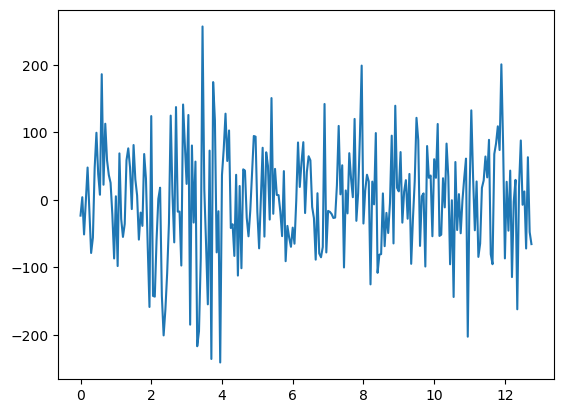

In [6]:
plt.plot(t, grad_delta_tdnll)
plt.show()

In [7]:
_, grad_logv_tdnll = tdnll_appx(
    x,
    delta,
    logv,
    a,
    eta,
    ts,
    fix_logv=False,
    fix_delta=True,
    fix_a=True,
    fix_eta=True,
)

grad_logv_nd = nd.Gradient(
    lambda _logv: tdnll_appx(
        x,
        delta,
        _logv,
        a,
        eta,
        ts,
        fix_logv=True,
        fix_delta=True,
        fix_a=True,
        fix_eta=True,
    )[0]
)(logv)

np.stack((grad_logv_tdnll, grad_logv_nd)).T

array([[-4299.43580976, -4299.43580975],
       [-1635.00777513, -1635.00777513],
       [   13.56815444,    13.56815444]])

In [8]:
_, grad_a_tdnll = tdnll_appx(
    x,
    delta,
    logv,
    a,
    eta,
    ts,
    fix_logv=True,
    fix_delta=True,
    fix_a=False,
    fix_eta=True,
)

grad_a_nd = nd.Gradient(
    lambda _a: tdnll_appx(
        x,
        delta,
        logv,
        _a,
        eta,
        ts,
        fix_logv=True,
        fix_delta=True,
        fix_a=True,
        fix_eta=True,
    )[0]
)(a)[1:]

np.stack((grad_a_tdnll, grad_a_nd)).T

array([[  875.36919429,   875.36919429],
       [  905.17903284,   905.17903284],
       [  178.52926698,   178.52926698],
       [ 1245.56354926,  1245.56354926],
       [ 1342.76463392,  1342.76463392],
       [  247.78494334,   247.78494334],
       [ -267.86268467,  -267.86268467],
       [  804.6598191 ,   804.6598191 ],
       [  454.54043781,   454.54043781],
       [  647.70171483,   647.70171483],
       [  402.23384875,   402.23384875],
       [ 1616.41762976,  1616.41762976],
       [ 1672.29146271,  1672.29146271],
       [  -21.67135019,   -21.67135019],
       [  240.38967193,   240.38967193],
       [  564.08536283,   564.08536283],
       [  207.12804183,   207.12804183],
       [ 1990.02737736,  1990.02737736],
       [ 1113.05300248,  1113.05300248],
       [  841.73926591,   841.73926591],
       [ 1876.70578179,  1876.70578179],
       [  799.03510085,   799.03510085],
       [ 1374.1635908 ,  1374.1635908 ],
       [ 1252.77758507,  1252.77758507],
       [  660.65

In [9]:
_, grad_eta_tdnll = tdnll_appx(
    x,
    delta,
    logv,
    a,
    eta,
    ts,
    fix_logv=True,
    fix_delta=True,
    fix_a=True,
    fix_eta=False,
)

grad_eta_nd = nd.Gradient(
    lambda _eta: tdnll_appx(
        x,
        delta,
        logv,
        a,
        _eta,
        ts,
        fix_logv=True,
        fix_delta=True,
        fix_a=True,
        fix_eta=True,
    )[0]
)(eta)[1:]

np.stack((grad_eta_tdnll, grad_eta_nd)).T

array([[ 10576.45428023,  10576.45428005],
       [  1361.33310268,   1361.33310224],
       [ -3247.42173624,  -3247.42173672],
       [-12906.48521502, -12906.48521522],
       [-19856.89798179, -19856.89798242],
       [ 17882.01306616,  17882.01306568],
       [  -268.08347939,   -268.08347967],
       [  7077.50633164,   7077.50633121],
       [-11218.73870063, -11218.73870098],
       [   507.42616451,    507.42616408],
       [ -9305.88683294,  -9305.88683356],
       [  -398.07653241,   -398.07653296],
       [ -1402.99140701,  -1402.99140758],
       [  2421.6673315 ,   2421.6673314 ],
       [-31650.85498034, -31650.85498081],
       [ -1506.29824072,  -1506.2982414 ],
       [ -4496.19172893,  -4496.19172948],
       [-10413.67946864, -10413.67946911],
       [ 15807.17784988,  15807.17784967],
       [  -913.64256441,   -913.64256498],
       [-10697.38755766, -10697.38755818],
       [ 17225.11332697,  17225.11332649],
       [ -9508.76604503,  -9508.76604517],
       [ -3

## Estimate noise parameters with approximate NLL

In [25]:
NUM_NOISE_PARAMETERS = 3
NUM_NOISE_DATA_DIMENSIONS = 2


def tdnoisefit(
    x: ArrayLike,
    *,
    v0: ArrayLike | None = None,
    mu0: ArrayLike | None = None,
    a0: ArrayLike | None = None,
    eta0: ArrayLike | None = None,
    ts: float = 1.0,
    fix_v: bool = False,
    fix_mu: bool = False,
    fix_a: bool = True,
    fix_eta: bool = True,
) -> tuple[dict, float, dict]:
    r"""
    Compute time-domain noise model parameters.

    Computes the noise parameters sigma and the underlying signal vector ``mu``
    for the data matrix ``x``, where the columns of ``x`` are each noisy
    measurements of ``mu``.

    Parameters
    ----------
    x : ndarray
        Data array.
    v0 : ndarray, optional
        Initial guess, noise model parameters with size (3,), expressed as
        variance amplitudes.
    mu0 : ndarray, optional
        Initial guess, signal vector with size (n,).
    a0 : ndarray, optional
        Initial guess, amplitude vector with size (m,).
    eta0 : ndarray, optional
        Initial guess, delay vector with size (m,).
    ts : float, optional
        Sampling time
    fix_v : bool, optional
        Noise variance parameters.
    fix_mu : bool, optional
        Signal vector.
    fix_a : bool, optional
        Amplitude vector.
    fix_eta : bool, optional
        Delay vector.

    Returns
    -------
    p : dict
        Output parameter dictionary containing:
            var : ndarray
                Noise parameters, expressed as variance amplitudes.
            mu : ndarray
                Signal vector.
            a : ndarray
                Amplitude vector.
            eta : ndarray
                Delay vector.
    fval : float
        Value of NLL cost function from FMINUNC
    Diagnostic : dict
        Dictionary containing diagnostic information
            err : dic
                Dictionary containing  error of the parameters.
            grad : ndarray
                Negative loglikelihood cost function gradient from
                scipy.optimize.minimize BFGS method.
            hessian : ndarray
                Negative loglikelihood cost function hessian from
                scipy.optimize.minimize BFGS method.
    """
    if fix_v and fix_mu and fix_a and fix_eta:
        msg = "All variables are fixed"
        raise ValueError(msg)
    # Parse and validate function inputs
    x = np.asarray(x)
    if x.ndim != NUM_NOISE_DATA_DIMENSIONS:
        msg = "Data array x must be 2D"
        raise ValueError(msg)
    n, m = x.shape

    if v0 is None:
        v0 = np.mean(np.var(x, 1)) * np.ones(NUM_NOISE_PARAMETERS)
    else:
        v0 = np.asarray(v0)
        if v0.size != NUM_NOISE_PARAMETERS:
            msg = (
                "Noise parameter array logv must have "
                f"{NUM_NOISE_PARAMETERS} elements."
            )
            raise ValueError(msg)

    if mu0 is None:
        mu0 = np.mean(x, 1)
    else:
        mu0 = np.asarray(mu0)
        if mu0.size != n:
            msg = "Size of mu0 is incompatible with data array x."
            raise ValueError(msg)

    scale = thz.noiseamp(np.sqrt(v0), x[:, 0], ts)
    delta0 = (x[:, 0] - mu0) / scale

    if a0 is None:
        a0 = np.ones(m)
    else:
        a0 = np.asarray(a0)
        if a0.size != m:
            msg = "Size of a0 is incompatible with data array x."
            raise ValueError(msg)

    if eta0 is None:
        eta0 = np.zeros(m)
    else:
        eta0 = np.asarray(eta0)
        if eta0.size != m:
            msg = "Size of eta0 is incompatible with data array x."
            raise ValueError(msg)

    # Set initial guesses for all free parameters
    x0 = np.array([])
    if not fix_v:
        # Replace log(x) with -inf when x <= 0
        logv0 = np.ma.log(v0).filled(-np.inf)
        x0 = np.concatenate((x0, logv0))
    if not fix_mu:
        x0 = np.concatenate((x0, mu0))
    if not fix_a:
        x0 = np.concatenate((x0, a0[1:] / a0[0]))
    if not fix_eta:
        x0 = np.concatenate((x0, eta0[1:] - eta0[0]))

    # Bundle free parameters together into objective function
    def objective(_p):
        if fix_v:
            _logv = np.ma.log(v0).filled(-np.inf)
        else:
            _logv = _p[:3]
            _p = _p[3:]
        if fix_mu:
            _delta = delta0
        else:
            _delta = _p[:n]
            _p = _p[n:]
        if fix_a:
            _a = a0
        else:
            _a = np.concatenate((np.array([1.0]), _p[: m - 1]))
            _p = _p[m - 1 :]
        if fix_eta:
            _eta = eta0
        else:
            _eta = np.concatenate((np.array([0.0]), _p[: m - 1]))
        return tdnll_appx(
            x.T,
            _delta,
            _logv,
            _a,
            _eta,
            ts,
            fix_logv=fix_v,
            fix_delta=fix_mu,
            fix_a=fix_a,
            fix_eta=fix_eta,
        )

    # Minimize cost function with respect to free parameters
    out = minimize(
        objective,
        x0,
        method="BFGS",
        jac=True,
        options={
            "gtol": 1e-3,
        },
    )

    # Parse output
    p = {}
    x_out = out.x
    if fix_v:
        p["var"] = v0
    else:
        p["var"] = np.exp(x_out[:3])
        x_out = x_out[3:]

    if fix_mu:
        p["mu"] = mu0
    else:
        p["mu"] = x[:, 0] - x_out[:n] * scale
        x_out = x_out[n:]

    if fix_a:
        p["a"] = a0
    else:
        p["a"] = np.concatenate(([1], x_out[: m - 1]))
        x_out = x_out[m - 1 :]

    if fix_eta:
        p["eta"] = eta0
    else:
        p["eta"] = np.concatenate(([0], x_out[: m - 1]))

    p["ts"] = ts

    diagnostic = {
        "grad": out.jac,
        "cov": out.hess_inv,
        "err": {
            "var": np.array([]),
            "mu": np.array([]),
            "a": np.array([]),
            "eta": np.array([]),
        },
        "success": out.success,
        "status": out.status,
        "message": out.message,
        "nfev": out.nfev,
        "njev": out.njev,
        "nit": out.nit,
    }
    err = np.sqrt(np.diag(diagnostic["cov"]))
    if not fix_v:
        # Propagate error from log(V) to V
        diagnostic["err"]["var"] = np.sqrt(
            np.diag(np.diag(p["var"]) @ diagnostic["cov"][0:3, 0:3])
            @ np.diag(p["var"])
        )
        err = err[3:]

    if not fix_mu:
        diagnostic["err"]["mu"] = err[:n] * scale
        err = err[n:]

    if not fix_a:
        diagnostic["err"]["a"] = np.concatenate(([0], err[: m - 1]))
        err = err[m - 1 :]

    if not fix_eta:
        diagnostic["err"]["eta"] = np.concatenate(([0], err[: m - 1]))

    return p, out.fun, diagnostic

In [26]:
result = tdnoisefit(x.T, ts=ts)

In [27]:
print(result[2]["message"])

Optimization terminated successfully.


In [28]:
var_out = result[0]["var"] * m / (m - 1)
var_err = result[2]["err"]["var"] * m / (m - 1)
for val_in, val_out, err in zip(sigma**2, var_out, var_err):
    print(f"Input: {val_in:6.4g}\t Output: {val_out:6.4g} ± {err:6.4g}")

Input:  1e-10	 Output: 9.485e-11 ± 3.399e-12
Input: 0.0001	 Output: 0.0001205 ± 5.585e-06
Input:  1e-06	 Output: 1.989e-07 ± 1.16e-08


In [13]:
result_exact = thz.tdnoisefit(
    x.T,
    v0=result[0]["var"],
    mu0=result[0]["mu"],
    a0=result[0]["a"],
    eta0=result[0]["eta"],
    ts=ts,
)

In [14]:
print(result_exact[2]["message"])

Desired error not necessarily achieved due to precision loss.


In [15]:
var_out = result_exact[0]["var"] * m / (m - 1)
var_err = result_exact[2]["err"]["var"] * m / (m - 1)
for val_in, val_out, err in zip(sigma**2, var_out, var_err):
    print(f"Input: {val_in:6.4g}\t Output: {val_out:6.4g} ± {err:6.4g}")

Input:  1e-10	 Output: 9.992e-11 ± 1.332e-12
Input: 0.0001	 Output: 9.855e-05 ± 2.584e-06
Input:  1e-06	 Output: 8.976e-07 ± 8.098e-08


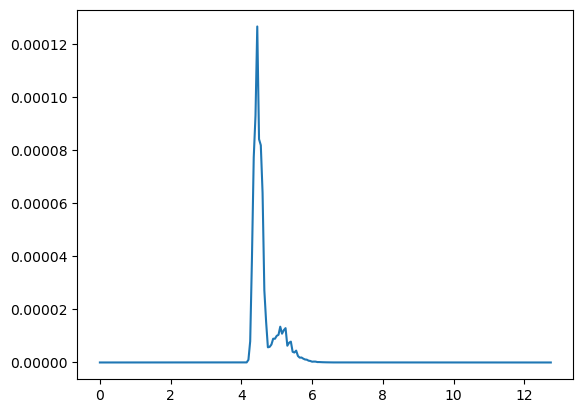

In [16]:
plt.plot(t, np.var(x, axis=0))
plt.show()

In [18]:
np.max(np.var(x, axis=0)) / np.min(np.var(x, axis=0))

2105507.818113499